In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import warnings

warnings.filterwarnings('ignore')

In [7]:
import pandas as pd
import numpy as np

In [8]:
n_splits = 3
random_seed = 2025

# Data

In [9]:
train_sleep_file_path = "../data/train/raw/train_sleep.csv"
train_activity_file_path = "../data/train/raw/train_activity.csv"
train_label_file_path = "../data/train/label/sleep/training_label.csv"

test_sleep_file_path = "../data/validation/raw/val_sleep.csv"
test_activity_file_path = "../data/validation/raw/val_activity.csv"
test_label_file_path = "../data/validation/label/sleep/val_label.csv"

In [10]:
train_label = pd.read_csv(train_label_file_path)
train_sleep = pd.read_csv(train_sleep_file_path)
train_activity = pd.read_csv(train_activity_file_path)

test_label = pd.read_csv(test_label_file_path)
test_sleep = pd.read_csv(test_sleep_file_path)
test_activity = pd.read_csv(test_activity_file_path)

In [11]:
# sleep + label
train = train_sleep.merge(train_label, left_on='EMAIL', right_on='SAMPLE_EMAIL')
test = test_sleep.merge(test_label, left_on='EMAIL', right_on='SAMPLE_EMAIL')
train.drop(['SAMPLE_EMAIL'], axis=1, inplace=True)
test.drop(['SAMPLE_EMAIL'], axis=1, inplace=True)

# sleep + activity
train = pd.concat([train, train_activity.drop(['EMAIL'], axis=1)], axis=1)
test = pd.concat([test, test_activity.drop(['EMAIL'], axis=1)], axis=1)

In [12]:
label_encoder = {'CN': 0, 'MCI': 1, 'Dem': 2}

In [13]:
train['label'] = train['DIAG_NM'].map(label_encoder)
test['label'] = test['DIAG_NM'].map(label_encoder)
train.drop(['DIAG_NM'], axis=1, inplace=True)
test.drop(['DIAG_NM'], axis=1, inplace=True)

In [14]:
train.shape, test.shape

((9705, 67), (2478, 67))

# train + test

In [15]:
all_data = pd.concat([train, test], axis=0)
all_data = all_data.drop(["label"], axis=1) # 타겟값 제거

In [16]:
all_data.columns, len(all_data.columns) # 66

(Index(['EMAIL', 'sleep_awake', 'sleep_bedtime_end', 'sleep_bedtime_start',
        'sleep_breath_average', 'sleep_deep', 'sleep_duration',
        'sleep_efficiency', 'sleep_hr_5min', 'sleep_hr_average',
        'sleep_hr_lowest', 'sleep_hypnogram_5min', 'sleep_is_longest',
        'sleep_light', 'sleep_midpoint_at_delta', 'sleep_midpoint_time',
        'sleep_onset_latency', 'sleep_period_id', 'sleep_rem', 'sleep_restless',
        'sleep_rmssd', 'sleep_rmssd_5min', 'sleep_score',
        'sleep_score_alignment', 'sleep_score_deep', 'sleep_score_disturbances',
        'sleep_score_efficiency', 'sleep_score_latency', 'sleep_score_rem',
        'sleep_score_total', 'sleep_temperature_delta',
        'sleep_temperature_deviation', 'sleep_total',
        'CONVERT(sleep_hr_5min USING utf8)',
        'CONVERT(sleep_hypnogram_5min USING utf8)',
        'CONVERT(sleep_rmssd_5min USING utf8)', 'activity_average_met',
        'activity_cal_active', 'activity_cal_total', 'activity_class_5min',


# feature selection

In [17]:
all_data = all_data.select_dtypes(include=[int, float])  # 숫자형 데이터만
selected_features = all_data.columns

In [18]:
selected_features.values, len(selected_features) # 51

(array(['sleep_awake', 'sleep_breath_average', 'sleep_deep',
        'sleep_duration', 'sleep_efficiency', 'sleep_hr_average',
        'sleep_hr_lowest', 'sleep_is_longest', 'sleep_light',
        'sleep_midpoint_at_delta', 'sleep_midpoint_time',
        'sleep_onset_latency', 'sleep_period_id', 'sleep_rem',
        'sleep_restless', 'sleep_rmssd', 'sleep_score',
        'sleep_score_alignment', 'sleep_score_deep',
        'sleep_score_disturbances', 'sleep_score_efficiency',
        'sleep_score_latency', 'sleep_score_rem', 'sleep_score_total',
        'sleep_temperature_delta', 'sleep_temperature_deviation',
        'sleep_total', 'activity_average_met', 'activity_cal_active',
        'activity_cal_total', 'activity_daily_movement', 'activity_high',
        'activity_inactive', 'activity_inactivity_alerts', 'activity_low',
        'activity_medium', 'activity_met_min_high',
        'activity_met_min_inactive', 'activity_met_min_low',
        'activity_met_min_medium', 'activity_non_w

# 데이터 다운캐스팅

In [19]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2  # 1MB = 1024**2 Byte
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == "object":
            pass
        elif dtype_name == "bool":
            df[col] = df[col].astype("int8")
        elif dtype_name.startswith("int") or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast="integer")
        else:
            df[col] = pd.to_numeric(df[col], downcast="float")
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print("{:.1f}% 압축됨".format(100 * (start_mem - end_mem) / start_mem))

    return df


all_data = downcast(all_data)

73.1% 압축됨


# 데이터 나누기

In [20]:
merged_df = pd.concat([all_data, train[['EMAIL', 'label']]], axis=1)

X_test = merged_df.loc[test.index, selected_features]
y_test = merged_df.loc[test.index, 'label']

merged_df = merged_df.loc[:train.index[-1]]

# DIAG_NM(label) 비율

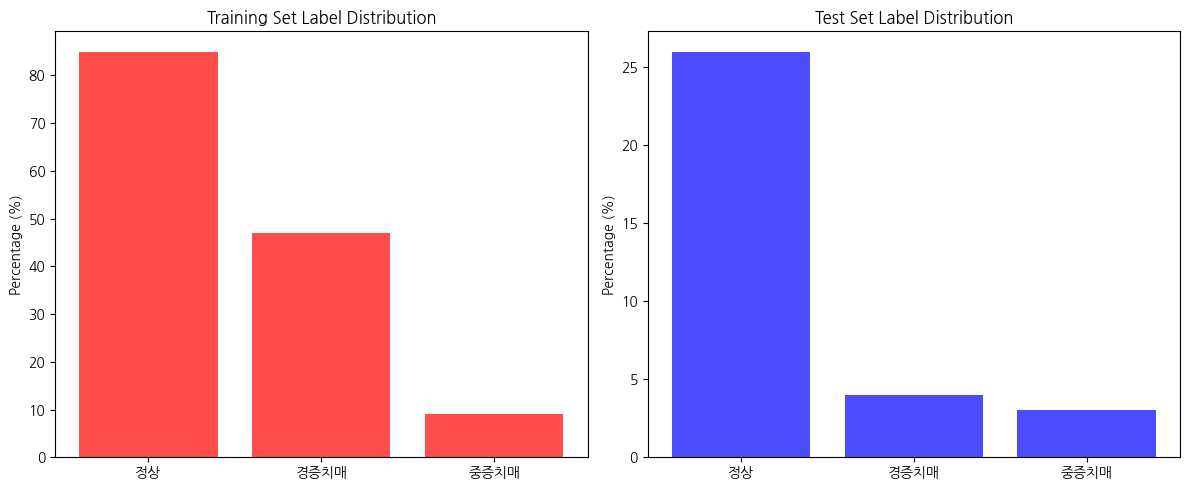

In [21]:
import matplotlib.pyplot as plt

# Compute class distributions
class_distribution_train = train_label['DIAG_NM'].value_counts()
class_distribution_test = test_label['DIAG_NM'].value_counts() 

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot training set distribution
axes[0].bar(class_distribution_train.index, class_distribution_train.values, color="red", alpha=0.7)
axes[0].set_xlabel(None)
axes[0].set_ylabel("Percentage (%)")
axes[0].set_title("Training Set Label Distribution")
axes[0].set_xticks([0, 1, 2], ["정상", "경증치매", "중증치매"])


# Plot validation set distribution
axes[1].bar(class_distribution_test.index, class_distribution_test.values, color="blue", alpha=0.7)
axes[1].set_xlabel(None)
axes[1].set_ylabel("Percentage (%)")
axes[1].set_title("Test Set Label Distribution")
axes[1].set_xticks([0, 1, 2], ["정상", "경증치매", "중증치매"])

# Display the plot
plt.tight_layout()
plt.show()

# 모델 학습 및 성능 검증

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# 모델 학습 및 평가
models = {
    "Lasso Regression": LogisticRegression(
        penalty="l1", solver="liblinear", multi_class="ovr"
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=random_seed
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100, random_state=random_seed, n_jobs=-1
    ),
}

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report

def evaluate_model(name, model, merged_df, n_splits=n_splits):
    acc_scores = []
    f1_scores = []
    class_report_list = []
    folds = []

    # unique EMAIL, label 쌍 추출
    unique_patient_labels = merged_df[["EMAIL", "label"]].drop_duplicates()

    # StratifiedKFold를 사용하여 라벨 비율을 유지하면서 Fold를 생성
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

    for fold_idx, (train_idx, val_idx) in enumerate(
        skf.split(unique_patient_labels["EMAIL"], unique_patient_labels["label"])
    ):
        # 학습/검증 데이터 이메일 리스트 추출
        train_emails = unique_patient_labels.iloc[train_idx]["EMAIL"]
        val_emails = unique_patient_labels.iloc[val_idx]["EMAIL"]

        # 이메일 기준으로 원본 데이터에서 train/validation 데이터 생성
        X_train = merged_df[merged_df["EMAIL"].isin(train_emails)].copy()
        X_val = merged_df[merged_df["EMAIL"].isin(val_emails)].copy()

        y_train = X_train["label"]
        y_val = X_val["label"]
        X_train.drop(["EMAIL", "label"], axis=1, inplace=True)
        X_val.drop(["EMAIL", "label"], axis=1, inplace=True)

        # 모델 학습
        model.fit(X_train, y_train)

        # 모델 예측
        y_pred = model.predict(X_val)

        # 평가
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average="weighted")  # 불균형 데이터 고려
        acc_scores.append(acc)
        f1_scores.append(f1)

        # Classification Report 저장
        report = classification_report(y_val, y_pred, output_dict=True)
        class_report_list.append(pd.DataFrame(report).T)

        folds.append((X_train, X_val, y_train, y_val))

    # Classification Report 평균
    avg_class_report = pd.concat(class_report_list).groupby(level=0).mean()

    # Accuracy 및 F1-score 평균 출력
    print("#" * 40, f"Model: {name}", "#" * 40)
    print(f"=== Average Classification Report ===")
    print(avg_class_report)
    print(f"Average Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Average F1-score: {np.mean(f1_scores):.4f}")
    print("=" * 60)

    return name, model, folds


models_ = {}
folds_ = {}

# 모델별 평가 실행
for name, model in models.items():
    name_, model_, fold_ = evaluate_model(name, model, merged_df)
    models_[name] = model_
    folds_[name] = fold_

######################################## Model: Lasso Regression ########################################
=== Average Classification Report ===
              precision    recall  f1-score      support
0              0.607554  0.796841  0.688963  1927.000000
1              0.369319  0.210734  0.267555  1117.666667
2              0.281203  0.095611  0.136234   190.333333
accuracy       0.552646  0.552646  0.552646     0.552646
macro avg      0.419359  0.367728  0.364251  3235.000000
weighted avg   0.507750  0.552646  0.511519  3235.000000
Average Accuracy: 0.5526
Average F1-score: 0.5115
######################################## Model: Gradient Boosting ########################################
=== Average Classification Report ===
              precision    recall  f1-score      support
0              0.604989  0.771101  0.676805  1927.000000
1              0.371788  0.236851  0.285416  1117.666667
2              0.307581  0.099420  0.132628   190.333333
accuracy       0.546106  0.546106 

# Test dataset 예측 결과

In [24]:
# Test Set 성능 평가
print("\n", "=" * 40, "TEST SET EVALUATION", "=" * 40, "\n")

for name, model in models_.items():
    print(f"=== Evaluating {name} on Test Set ===")

    # 테스트 데이터 예측
    y_test_pred = model.predict(X_test)

    # 테스트 데이터 평가
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")  # 불균형 고려
    test_report = classification_report(y_test, y_test_pred, output_dict=True)

    # 결과 출력
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test F1-score: {test_f1:.4f}")
    print(f"Test Classification Report:\n", pd.DataFrame(test_report).T)
    print("=" * 60)


 ======================================== TEST SET EVALUATION ======================================== 

=== Evaluating Lasso Regression on Test Set ===
Test Accuracy: 0.5472
Test F1-score: 0.5057
Test Classification Report:
               precision    recall  f1-score      support
0              0.562384  0.816216  0.665932  2590.000000
1              0.481884  0.282678  0.356330  1882.000000
2              0.709677  0.136364  0.228769   484.000000
accuracy       0.547215  0.547215  0.547215     0.547215
macro avg      0.584648  0.411753  0.417010  4956.000000
weighted avg   0.546199  0.547215  0.505670  4956.000000
=== Evaluating Gradient Boosting on Test Set ===
Test Accuracy: 0.5839
Test F1-score: 0.5683
Test Classification Report:
               precision    recall  f1-score      support
0              0.594260  0.759459  0.666780  2590.000000
1              0.533967  0.417641  0.468694  1882.000000
2              0.810345  0.291322  0.428571   484.000000
accuracy       0.583939 

# 모델 저장

In [26]:
import pickle

with open("model_baseline", "wb") as f:
    pickle.dump(model_, f)